<a href="https://colab.research.google.com/github/abdullah90907/real-time-object-detection-model/blob/main/real_time_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
!pip install supervision
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv
from IPython.display import display, HTML, Image
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
class VideoObjectDetector:
    def __init__(self):
        """Initialize the YOLO model from Hugging Face"""
        print("Loading YOLO model...")
        self.model = YOLO("yolov8x.pt")  # Loading the latest YOLO model
        print("Model loaded successfully!")

    def process_video(self, video_path):
        """
        Process video and detect objects

        Parameters:
        video_path: Path to the video file

        Returns:
        DataFrame with detection results
        """
        print("Starting video processing...")

        # Initialize video capture
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Initialize results storage
        all_detections = []
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Run detection on frame
            results = self.model.predict(frame)

            # Process detections
            for r in results[0].boxes.data.tolist():
                x1, y1, x2, y2, conf, class_id = r

                detection = {
                    'frame': frame_count,
                    'time': frame_count/fps,
                    'class': self.model.names[int(class_id)],
                    'confidence': conf,
                    'x1': x1,
                    'y1': y1,
                    'x2': x2,
                    'y2': y2
                }
                all_detections.append(detection)

            frame_count += 1
            if frame_count % 30 == 0:  # Update progress every 30 frames
                print(f"Processed {frame_count}/{total_frames} frames ({(frame_count/total_frames*100):.1f}%)")

        cap.release()

        # Convert results to DataFrame
        df = pd.DataFrame(all_detections)
        return df

    def create_annotated_video(self, video_path, output_path):
        """
        Create annotated video with detected objects
        """
        print("Creating annotated video...")
        results = self.model.predict(video_path, save=True)
        print("Annotated video created successfully!")
        return results

    def analyze_results(self, df):
        """
        Analyze detection results and create visualizations
        """
        print("\n📊 Analysis Results:")

        # Basic statistics
        total_objects = len(df)
        unique_classes = df['class'].nunique()
        avg_confidence = df['confidence'].mean()

        print(f"Total objects detected: {total_objects}")
        print(f"Unique object classes: {unique_classes}")
        print(f"Average confidence score: {avg_confidence:.2f}")

        # Create visualizations
        plt.figure(figsize=(15, 10))

        # 1. Object frequency plot
        plt.subplot(2, 2, 1)
        class_counts = df['class'].value_counts()
        sns.barplot(x=class_counts.values[:10], y=class_counts.index[:10])
        plt.title('Top 10 Detected Objects')
        plt.xlabel('Count')

        # 2. Confidence distribution
        plt.subplot(2, 2, 2)
        sns.histplot(df['confidence'], bins=20)
        plt.title('Detection Confidence Distribution')
        plt.xlabel('Confidence Score')

        # 3. Objects over time
        plt.subplot(2, 2, (3, 4))
        time_series = df.groupby('frame')['class'].count()
        plt.plot(time_series.index, time_series.values)
        plt.title('Objects Detected Over Time')
        plt.xlabel('Frame Number')
        plt.ylabel('Number of Objects')

        plt.tight_layout()
        plt.show()

        return class_counts

In [ ]:
def main():
    """Main execution function"""
    # Create detector instance
    detector = VideoObjectDetector()

    # Upload video
    print("Please upload your video file...")
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]

    # Process video
    print("\nProcessing video...")
    results_df = detector.process_video(video_path)

    # Analyze results
    print("\nAnalyzing results...")
    class_counts = detector.analyze_results(results_df)

    # Create annotated video
    print("\nCreating annotated video...")
    detector.create_annotated_video(video_path, "annotated_video.mp4")

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(f'detection_results_{timestamp}.csv')
    print(f"\n💾 Results saved to detection_results_{timestamp}.csv")

    print("\n✨ Processing complete! Check the files section for:")
    print("1. CSV file with detailed detection data")
    print("2. Annotated video in runs/detect/predict/")

Loading YOLO model...


100%|██████████| 131M/131M [00:00<00:00, 204MB/s]


Model loaded successfully!
Please upload your video file...


Saving 14359967-hd_1280_720_30fps.mp4 to 14359967-hd_1280_720_30fps.mp4

Processing video...
Starting video processing...

0: 384x640 1 person, 20 cars, 5 buss, 4 trucks, 1 traffic light, 2909.2ms
Speed: 19.6ms preprocess, 2909.2ms inference, 36.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 20 cars, 6 buss, 4 trucks, 2681.5ms
Speed: 2.7ms preprocess, 2681.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 20 cars, 5 buss, 3 trucks, 3965.5ms
Speed: 2.8ms preprocess, 3965.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 20 cars, 1 motorcycle, 7 buss, 3 trucks, 2731.4ms
Speed: 2.8ms preprocess, 2731.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 20 cars, 1 motorcycle, 6 buss, 4 trucks, 1 traffic light, 2653.7ms
Speed: 3.6ms preprocess, 2653.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 19 c

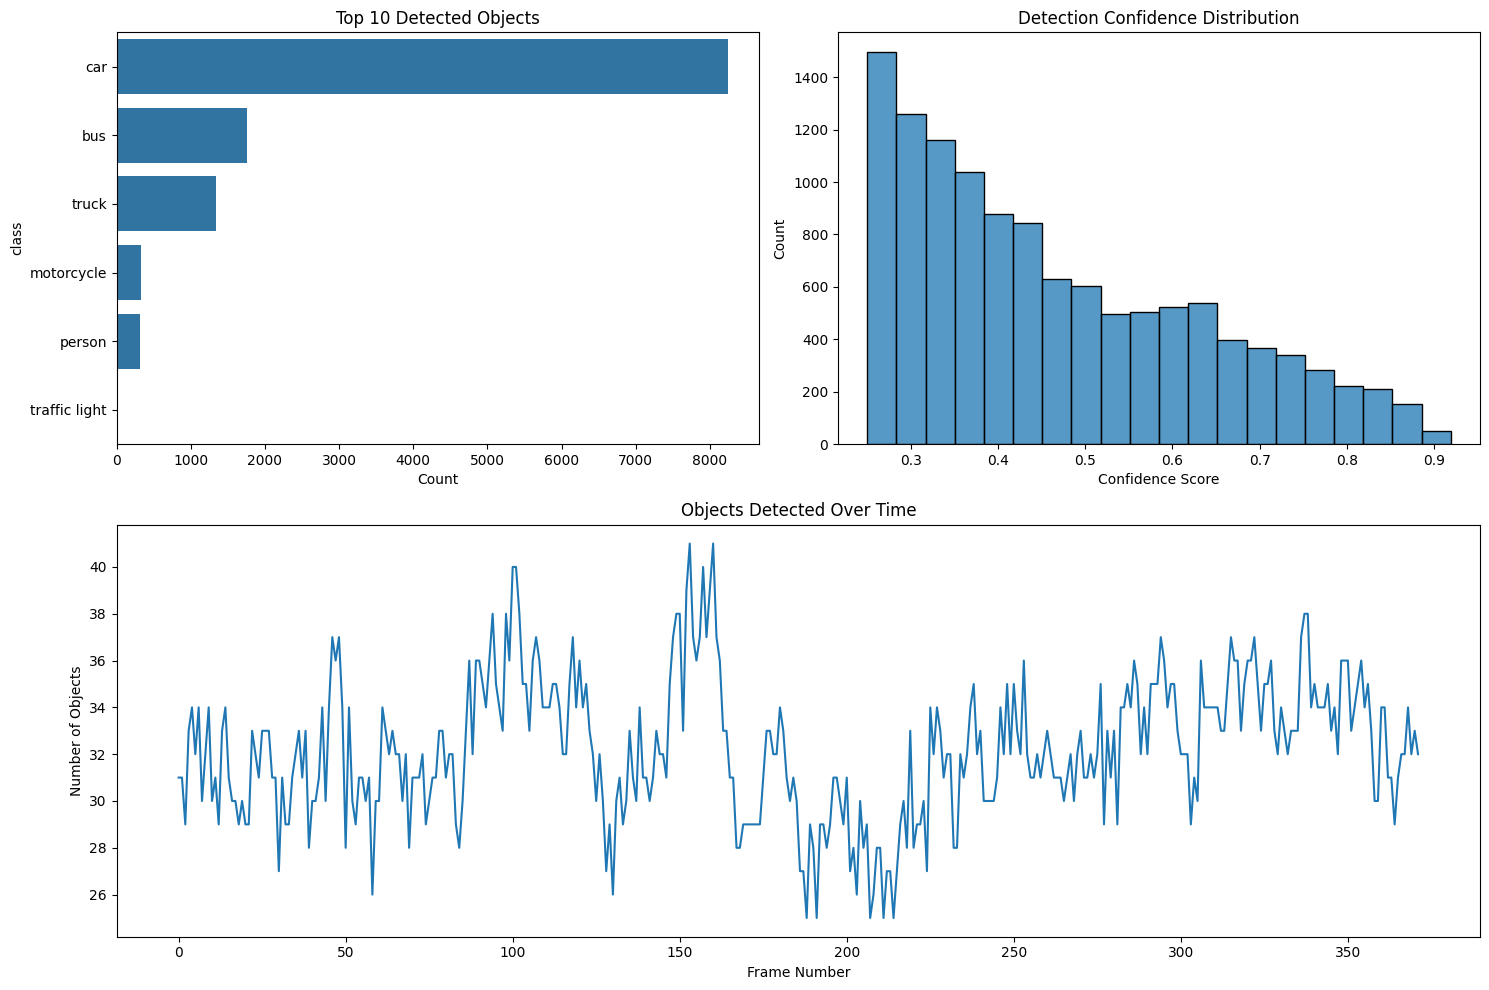


Creating annotated video...
Creating annotated video...


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/372) /content/14359967-hd_1280_720_30fps.mp4: 384x640 1 person, 20 cars, 5 buss, 4 trucks, 1 traffic light, 2636.5ms
video 1/1 (frame 2/372) /content/14359967-hd_1280_720_30fps.mp4: 384x640 1 person, 20 cars, 6 buss, 4 trucks, 2668.5ms
video 1/1 (frame 3/372) /content/14359967-hd_1280_720_30fps.mp4: 384x640 1 person, 20 cars, 5 buss, 3 trucks, 3751.5ms
video 1/1 (frame 4/372) /

In [ ]:
# Fifth Cell - Run the program
if __name__ == "__main__":
    main()